In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
##
from utils import *
from model import *
from analysis import *
##
import time
import seaborn as sns
from glob import glob as glob
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
gsname = 'gs0315'

### load data

In [3]:
gsdf = pd.read_csv('data/%s-summdf.csv'%gsname).astype(float)
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,mse-e,testacc-i,acc2-i,mse-i,testacc-l,acc2-l,mse-l,testacc-m,acc2-m,mse-m
0,0.0,2.441182,69.986158,69.986158,0.006716,0.0,1.0,1.0,1.0,1.0,...,0.012453,0.981992,0.981944,0.127271,0.981992,0.981944,0.076977,0.981992,0.981959,0.101725
1,0.0,2.800250,3.423864,3.423864,0.252022,0.0,1.0,1.0,1.0,1.0,...,0.010453,0.981196,0.979300,0.124865,0.981199,0.979299,0.074685,0.981198,0.979899,0.099385
2,0.0,5.569806,15.181870,15.181870,0.022646,0.0,1.0,1.0,1.0,1.0,...,0.012520,0.981941,0.981775,0.127099,0.981941,0.981777,0.076660,0.981941,0.981828,0.101659
3,0.0,6.295557,76.826490,76.826490,0.079757,0.0,1.0,1.0,1.0,1.0,...,0.012371,0.524961,0.518419,0.014053,0.517383,0.502690,0.054682,0.532628,0.712991,0.042593
4,0.0,7.535761,59.273272,59.273272,0.027033,0.0,1.0,1.0,1.0,1.0,...,0.012409,0.924292,0.500000,0.030181,0.981854,0.500000,0.039022,0.981901,0.957223,0.068852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116918,0.0,89.618909,92.442301,92.442301,0.069351,0.0,1.0,1.0,1.0,1.0,...,0.012244,0.664257,0.500000,0.013921,0.981603,0.500000,0.038752,0.981724,0.956086,0.068658
116919,0.0,91.585115,93.525567,93.525567,0.893328,0.0,1.0,1.0,1.0,1.0,...,0.010280,0.615936,0.500000,0.013865,0.976333,0.500000,0.033796,0.978081,0.929113,0.062114
116920,0.0,92.197776,91.239045,91.239045,0.325176,0.0,1.0,1.0,1.0,1.0,...,0.011593,0.645088,0.500000,0.013873,0.980044,0.500000,0.037161,0.980638,0.948204,0.066667
116921,0.0,92.729146,93.603257,93.603257,0.269567,0.0,1.0,1.0,1.0,1.0,...,0.011652,0.649562,0.500000,0.013832,0.980384,0.500000,0.037500,0.980879,0.950012,0.067001


In [4]:
## load human data
hdf = pd.read_csv('../human_data.csv')
humanD = {}
for c in ['blocked','interleaved','early','middle','late']:
  humanD[c[0]] = hdf.loc[:,('%s mean')%c].values.T[-40:].mean()
## test acc: difference to human
for c in ['b','i','e','m','l']:
  gsdf['%s-test_diff'%c] = np.abs(gsdf.loc[:,'testacc-%s'%c] - humanD[c])
## block+interleaved mse
gsdf.loc[:,'mse-bi'] = gsdf.loc[:,'mse-i']+gsdf.loc[:,'mse-b']

### plt single condition

In [22]:
def save_and_close(param_str,rank,mse):
  plt.title(param_str[:120])
  plt.savefig("figures/top40/%s-%i-mse%.3f-%s.png"%(gsname,rank,mse,param_str))
  plt.close('all')
  
def pipeline(row,ns=50):
  """ 
  each step of the pipeline involves 
    running a csw experiment on a param contained in row
    calculating a metric on exp_batch_data
    plotting and saving
  """
  mse = dict(row)['mse-bi'].round(3)
  ## RUN EXP
  args,paramstr = get_argsD(row)
  args['sem']['skipt1']=True
  exp_batch_data = run_batch_exp_curr(ns,args,condL) # [curr],[seeds],{data}
#   print(len(exp_batch_data),len(exp_batch_data[0]))
#   print(exp_batch_data[0][0].keys())
  ## ACCURACY
  plt_acc(exp_batch_data)
  save_and_close("acc-%s"%paramstr,rank,mse)
  ## LC COUNTS VIOLIN
  plt_LC_violins(exp_batch_data)
  save_and_close("lc-%s"%paramstr,rank,mse)
  ## ajdusted rand
  plt_arscores(exp_batch_data)
  save_and_close("ar-%s"%paramstr,rank,mse)

# top 40 MSE analyses

5 2
dict_keys(['zt', 'xth', 'prior', 'like', 'post', 'exp'])
5 2
dict_keys(['zt', 'xth', 'prior', 'like', 'post', 'exp'])


KeyboardInterrupt: 

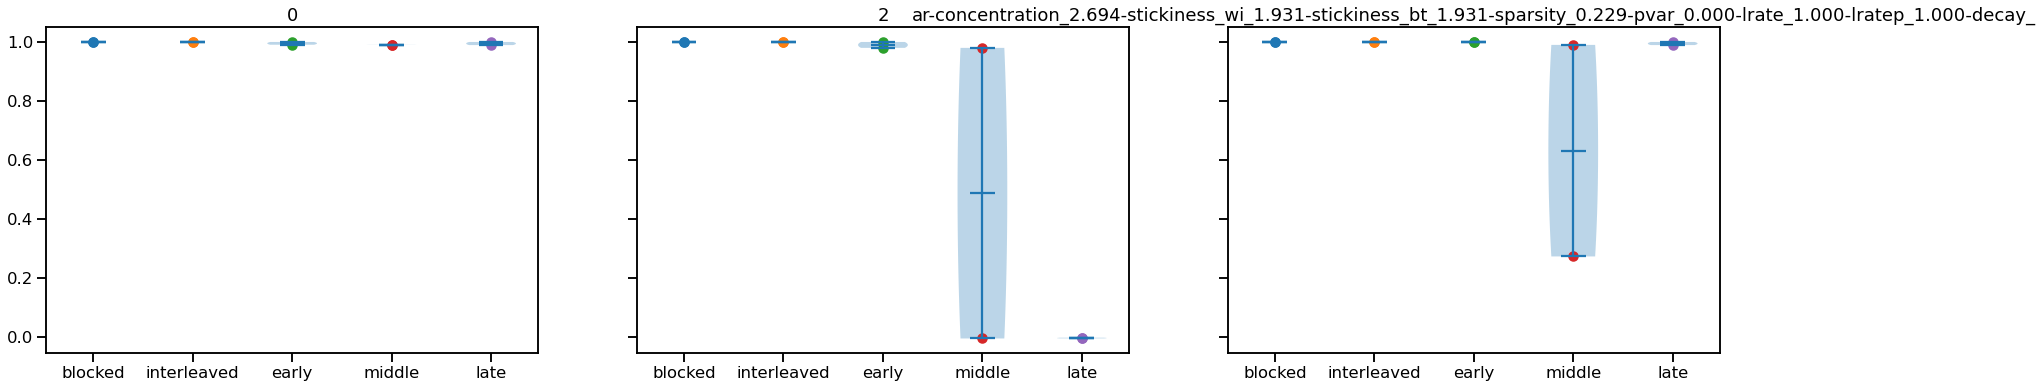

In [23]:
## LOOP
for rank,(idx,row) in enumerate(topKgsdf.iterrows()):
  pipeline(row,2)

In [12]:
TOP_K = 40
## select top40 MSE
topKgsdf = gsdf.sort_values('mse-bi').iloc[:TOP_K]
topKgsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,mse-l,testacc-m,acc2-m,mse-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff,mse-bi
86937,0.0,1.661468,1.747579,1.747579,0.229114,0.0,1.0,1.0,1.0,1.0,...,0.014347,0.620001,0.749005,0.017355,0.018763,0.005360,0.033968,0.070336,0.091353,0.008819
10606,0.0,2.694437,1.931349,1.931349,0.229177,0.0,1.0,1.0,1.0,1.0,...,0.021979,0.643046,0.689333,0.012742,0.008186,0.028500,0.006029,0.047291,0.129162,0.010524
67010,0.0,2.347461,1.957143,1.957143,0.247313,0.0,1.0,1.0,1.0,1.0,...,0.025955,0.684044,0.703567,0.010561,0.024722,0.000963,0.059390,0.006293,0.146697,0.010991
88818,0.0,4.293272,64.337511,64.337511,0.036864,0.0,1.0,1.0,1.0,1.0,...,0.025917,0.611707,0.693066,0.017445,0.068486,0.028735,0.073764,0.078630,0.149269,0.011572
8003,0.0,2.348400,42.912423,42.912423,0.041510,0.0,1.0,1.0,1.0,1.0,...,0.029245,0.587026,0.682291,0.020667,0.068471,0.044637,0.073749,0.103311,0.165760,0.011972
114917,0.0,7.375362,75.406994,75.406994,0.058286,0.0,1.0,1.0,1.0,1.0,...,0.028765,0.590128,0.686834,0.023313,0.068418,0.030939,0.073696,0.100209,0.162884,0.011990
89627,0.0,3.437381,44.794758,44.794758,0.060484,0.0,1.0,1.0,1.0,1.0,...,0.035521,0.588008,0.692910,0.022722,0.068410,0.043804,0.073688,0.102329,0.184225,0.012037
111304,0.0,6.607798,32.682211,32.682211,0.146089,0.0,1.0,1.0,1.0,1.0,...,0.038829,0.571755,0.709189,0.027462,0.068134,0.045027,0.073410,0.118583,0.196119,0.012075
112299,0.0,4.713105,31.901572,31.901572,0.088288,0.0,1.0,1.0,1.0,1.0,...,0.030491,0.581095,0.670682,0.019581,0.068322,0.057679,0.073600,0.109243,0.169163,0.012081
112098,0.0,4.095606,47.001628,47.001628,0.045657,0.0,1.0,1.0,1.0,1.0,...,0.034113,0.547084,0.660429,0.029965,0.068458,0.050899,0.073735,0.143253,0.186438,0.012218
